In [1]:
from risk_targeted_hazard import *

pd.set_option('display.precision', 2)

In [2]:
folder = 'data'

oq_id = [int(re.split('calc_|\.',name)[-2]) for name in glob.glob(str(Path(folder,'calc_*.hdf5')))][0]
file_id = str(Path(folder,f'calc_{oq_id}.hdf5'))

In [3]:
filename = str(Path(folder,f'design_{oq_id}.json'))
with open(filename, 'r') as f:
    results = json.load(f)
    
intensity_type = 'acc'
imtls = results['metadata'][f'{intensity_type}_imtls']
quantiles = results['metadata']['quantiles']
sites = pd.DataFrame(results['metadata']['sites'])
locations = sites.index.values
hazard_rps = results['hazard_design']['hazard_rps']

In [4]:
risk_assumptions = {}

beta = 0.6
risk_target = 1e-5  # this is for collapse, assuming aifr = 1e-6 and P(F|C)=0.1

# set the options for the design point
digits = 2
discrete_options = sigfig(np.concatenate([np.flip(np.array([0.1, 0.25, 0.5, 0.75])) * n for n in [1e-2,1e-3,1e-4,1e-5,1e-6]]),digits)

check that the risk_target and beta are consistent with the stored results

In [5]:
temp = results['risk_design']['acc']['risk_assumptions']
rs_idx = 0
if (temp[list(temp.keys())[rs_idx]]['risk_target'] != risk_target) or (temp[list(temp.keys())[0]]['beta'] != beta):
    raise NameError('Risk assumptions are not consistent.')
else:
    fragility_medians_stats = np.array(results['risk_design'][intensity_type]['stats_im_risk']['stats_fragility_risk'])
    hcurves_stats = np.array(results['hcurves']['hcurves_stats'])
    stats_im_hazard = np.array(results['hazard_design'][intensity_type]['stats_im_hazard'])

### match the median 1/500 for Wellington

In [7]:
# parameters to match the design point to 
site = 'Wellington'
target_rp = 500 
period = 0.5
imt = f'SA({period})'
q = 0.5 # the fractile of interest

design_point = 0.5  # place holder value for the design point


In [24]:
site_idx = sites.loc[site,'sids']
imt_idx = list(imtls.keys()).index(imt)
rp_idx = hazard_rps.index(target_rp)
q_idx = quantiles.index(q) + 1  # the first stat is mean and the quantiles follow it. 

target_im = stats_im_hazard[site_idx,imt_idx,rp_idx,q_idx]

median = fragility_medians_stats[site_idx,imt_idx,rs_idx,q_idx]
design_point = stats.lognorm(beta, scale=median).cdf(target_im)
design_point = find_nearest(design_point,discrete_options)

im_r, median = find_uniform_risk_intensity(hcurves_stats[site_idx,imt_idx,:,q_idx],imtls[imt],beta,risk_target,design_point)

print(f'Anchor point is P(LS|IM_D) = {design_point}.')
print(f'{site} {imt} design intensity is {im_r.round(2)}g, with a {(100*(im_r - target_im) / target_im).round(1)}% error compared to the APoE 1 / {target_rp} value.')

risk_assumptions['1/500_Median_Wellington'] = {'risk_target':risk_target,
                                'design_point':design_point,
                                'beta':beta}

Anchor point is P(LS|IM_D) = 0.00025.
Wellington SA(0.5) design intensity is 1.4g, with a -1.0% error compared to the APoE 1 / 500 value.


### match Z at median for Wellington

In [25]:
site_idx = sites.loc[site,'sids']
imt_idx = list(imtls.keys()).index(imt)
rp_idx = hazard_rps.index(target_rp)
q_idx = quantiles.index(q) + 1  # the first stat is mean and the quantiles follow it. 

Z = site_Z_values[site]
R = NZS1170_R_dict[500]
soil = 'C'
target_im = Z * R * Ch.loc[period,soil]

median = fragility_medians_stats[site_idx,imt_idx,rs_idx,q_idx]
design_point = stats.lognorm(beta, scale=median).cdf(target_im)
design_point = find_nearest(design_point,discrete_options)

im_r, median = find_uniform_risk_intensity(hcurves_stats[site_idx,imt_idx,:,q_idx],imtls[imt],beta,risk_target,design_point)

print(f'Anchor point is P(LS|IM_D) = {design_point}.')
print(f'{site} {imt} design intensity is {im_r.round(2)}g, with a {(100*(im_r - target_im) / target_im).round(1)}% error compared to the APoE 1 / {target_rp} value.')

risk_assumptions['Z_Median_Wellington'] = {'risk_target':risk_target,
                                'design_point':design_point,
                                'beta':beta}

Anchor point is P(LS|IM_D) = 5e-06.
Wellington SA(0.5) design intensity is 0.8g, with a 0.0% error compared to the APoE 1 / 500 value.


### match the median 1/500 across a range of sites

In [26]:
imt_idx = list(imtls.keys()).index(imt)
rp_idx = hazard_rps.index(target_rp)
q_idx = quantiles.index(q) + 1  # the first stat is mean and the quantiles follow it. 

risk_coeff = np.zeros([len(sites),len(discrete_options)])
for site in locations:
    site_idx = sites.loc[site,'sids']
    median = fragility_medians_stats[site_idx,imt_idx,rs_idx,q_idx]
    
    target_im = stats_im_hazard[site_idx,imt_idx,rp_idx,q_idx]
    potential_ims = stats.lognorm(beta, scale=median).ppf(discrete_options)
    risk_coeff[site_idx,:] = potential_ims / target_im
    
risk_coeff = pd.DataFrame(np.transpose(risk_coeff),index=discrete_options,columns=locations)
risk_coeff.insert(0,'Average',np.average(risk_coeff,axis=1))
risk_coeff
design_point = risk_coeff.index[np.abs(risk_coeff['Average']-1).argmin()]
risk_coeff.loc[design_point:design_point,:]

risk_assumptions['1/500_Median'] = {'risk_target':risk_target,
                                'design_point':design_point,
                                'beta':beta}

,Average,Dunedin,Christchurch,Auckland,Wellington
7.50e-03,2.30,2.41,2.16,2.77,1.86
5.00e-03,2.11,2.21,1.98,2.54,1.70
2.50e-03,1.84,1.93,1.72,2.21,1.48
1.00e-03,1.55,1.62,1.45,1.87,1.25
7.50e-04,1.47,1.54,1.38,1.77,1.19
5.00e-04,1.37,1.44,1.29,1.65,1.11
2.50e-04,1.23,1.29,1.15,1.48,0.99
1.00e-04,1.06,1.11,1.00,1.28,0.86
7.50e-05,1.02,1.07,0.95,1.22,0.82
5.00e-05,0.96,1.00,0.90,1.15,0.77


,Average,Dunedin,Christchurch,Auckland,Wellington
7.50e-05,1.02,1.07,0.95,1.22,0.82


### match Z at median across a range of sites

In [27]:
imt_idx = list(imtls.keys()).index(imt)
rp_idx = hazard_rps.index(target_rp)
q_idx = quantiles.index(q) + 1  # the first stat is mean and the quantiles follow it. 

R = NZS1170_R_dict[500]
soil = 'C'

risk_coeff = np.zeros([len(sites),len(discrete_options)])
for site in locations:
    site_idx = sites.loc[site,'sids']
    median = fragility_medians_stats[site_idx,imt_idx,rs_idx,q_idx]
    
    Z = site_Z_values[site]
    target_im = Z * R * Ch.loc[period,soil]
    
    potential_ims = stats.lognorm(beta, scale=median).ppf(discrete_options)
    risk_coeff[site_idx,:] = potential_ims / target_im
    
risk_coeff = pd.DataFrame(np.transpose(risk_coeff),index=discrete_options,columns=locations)
risk_coeff.insert(0,'Average',np.average(risk_coeff,axis=1))
risk_coeff
design_point = risk_coeff.index[np.abs(risk_coeff['Average']-1).argmin()]
risk_coeff.loc[design_point:design_point,:]

risk_assumptions['Z_Median'] = {'risk_target':risk_target,
                                'design_point':design_point,
                                'beta':beta}

,Average,Dunedin,Christchurch,Auckland,Wellington
7.50e-03,3.09,4.18,2.27,2.60,3.29
5.00e-03,2.83,3.84,2.08,2.39,3.02
2.50e-03,2.46,3.34,1.81,2.08,2.63
1.00e-03,2.08,2.82,1.53,1.75,2.22
7.50e-04,1.98,2.68,1.45,1.67,2.11
5.00e-04,1.84,2.50,1.36,1.55,1.97
2.50e-04,1.65,2.23,1.21,1.39,1.75
1.00e-04,1.43,1.93,1.05,1.20,1.52
7.50e-05,1.37,1.85,1.00,1.15,1.46
5.00e-05,1.29,1.74,0.95,1.08,1.37


,Average,Dunedin,Christchurch,Auckland,Wellington
7.50e-06,0.99,1.34,0.73,0.83,1.05


### Match 1/500 and Z across a range of sites and epistemic uncertainty

In [9]:
temp = results['risk_design']['acc']['risk_assumptions']
rs_idx = 0
if (temp[list(temp.keys())[rs_idx]]['risk_target'] != risk_target) or (temp[list(temp.keys())[0]]['beta'] != beta):
    raise NameError('Risk assumptions are not consistent.')
else:
    fragility_medians = np.array(results['risk_design'][intensity_type]['im_risk']['fragility_risk'])
    im_hazard = np.array(results['hazard_design'][intensity_type]['im_hazard'])


#### this could be steamlined to check multiple options for each i_rlz at the same time, instead of cycling through rlz for each option...

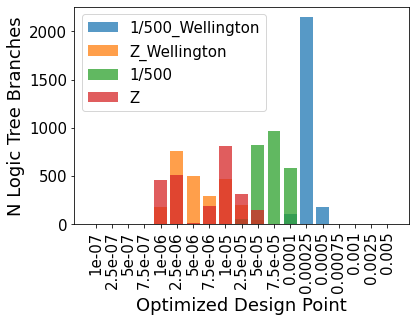

In [15]:
imt_idx = list(imtls.keys()).index(imt)
rp_idx = hazard_rps.index(target_rp)
[_,_,_,n_rlz] = fragility_medians.shape

R = NZS1170_R_dict[500]
soil = 'C'
site = 'Wellington'

for reference in ['1/500_Wellington','Z_Wellington']:
    design_points = np.zeros(n_rlz)
    for i_rlz in range(n_rlz):
        site_idx = sites.loc[site,'sids']
        median = fragility_medians[site_idx,imt_idx,rs_idx,i_rlz]

        if reference == 'Z_Wellington':
            Z = site_Z_values[site]
            target_im = Z * R * Ch.loc[period,soil]
        else:
            target_im = im_hazard[site_idx,imt_idx,rp_idx,i_rlz,0]

        design_points[i_rlz] = find_nearest(stats.lognorm(beta, scale=median).cdf(target_im),discrete_options)

    n,bins = np.histogram(design_points,bins=np.flip(discrete_options),weights=results['metadata']['rlz_weights'])
    x_ticks = range(len(n))
    x_labels = bins[:-1]
    _ = plt.bar(x_ticks,n*n_rlz,label=reference,alpha=0.75)
    _ = plt.xticks(x_ticks,x_labels,rotation=90)
    _ = plt.xlabel('Optimized Design Point')
    _ = plt.ylabel('N Logic Tree Branches')
    _ = plt.legend()

    design_point = x_labels[np.argmax(n)]
    risk_assumptions[reference] = {'risk_target':risk_target,
                                        'design_point':design_point,
                                        'beta':beta}
    
    

for reference in ['1/500','Z']: 
    risk_coeff = np.zeros([len(sites),len(discrete_options),n_rlz])
    design_points = np.zeros(n_rlz)
    for i_rlz in range(n_rlz):
        for site in locations:
            site_idx = sites.loc[site,'sids']
            median = fragility_medians[site_idx,imt_idx,rs_idx,i_rlz]

            if reference == 'Z':
                Z = site_Z_values[site]
                target_im = Z * R * Ch.loc[period,soil]               
            else:
                target_im = im_hazard[site_idx,imt_idx,rp_idx,i_rlz,0]

            potential_ims = stats.lognorm(beta, scale=median).ppf(discrete_options)
            risk_coeff[site_idx,:,i_rlz] = potential_ims / target_im

        avg_risk_coeff = np.nanmean(risk_coeff[:,:,i_rlz],axis=0)
        design_points[i_rlz] = discrete_options[np.abs(avg_risk_coeff-1).argmin()]

    n,bins = np.histogram(design_points,bins=np.flip(discrete_options),weights=results['metadata']['rlz_weights'])
    x_ticks = range(len(n))
    x_labels = bins[:-1]
    _ = plt.bar(x_ticks,n*n_rlz,label=reference,alpha=0.75)
    _ = plt.xticks(x_ticks,x_labels,rotation=90)
    _ = plt.xlabel('Optimized Design Point')
    _ = plt.ylabel('N Logic Tree Branches')
    _ = plt.legend()

    design_point = x_labels[np.argmax(n)]
    risk_assumptions[reference] = {'risk_target':risk_target,
                                        'design_point':design_point,
                                        'beta':beta}

## Results

In [30]:
summary = pd.DataFrame()
for key in risk_assumptions.keys():
    design_point = risk_assumptions[key]['design_point']
    summary.loc[key,'Design Point'] = design_point
    for site in ['Wellington','Christchurch','Dunedin','Auckland']:
        site_idx = sites.loc[site,'sids']
        median = fragility_medians_stats[site_idx,imt_idx,rs_idx,q_idx]
        summary.loc[key,f'{site}: {imt}'] = stats.lognorm(beta, scale=median).ppf(design_point)
summary

,Design Point,Wellington: SA(0.5),Christchurch: SA(0.5),Dunedin: SA(0.5),Auckland: SA(0.5)
1/500_Median_Wellington,2.50e-04,1.40,0.73,0.58,0.36
Z_Median_Wellington,5.00e-06,0.80,0.41,0.33,0.21
1/500_Median,7.50e-05,1.16,0.60,0.48,0.30
Z_Median,7.50e-06,0.84,0.44,0.35,0.22
1/500_Wellington,2.50e-04,1.40,0.73,0.58,0.36
Z_Wellington,2.50e-06,0.73,0.38,0.30,0.19
1/500,7.50e-05,1.16,0.60,0.48,0.30
Z,1.00e-05,0.88,0.45,0.36,0.23
